# Recipe_Ingredients_EDA_and_Clustering



1. Первичный обзор набора данных  
2. Определение наиболее часто встречающихся ингредиентов  
3. Подготовка данных для кластеризации (векторизация списков ингредиентов)  
4. Кластеризация рецептов с помощью алгоритма KMeans (2 кластера)  
5. Визуализация кластеров с помощью облаков слов  
6. Кластеризация с другим количеством кластеров (поиск более объяснимой структуры)  
7. Географическое разделение кухонь
8. Применение альтернативных алгоритмов кластеризации
9. Оценка качества кластеризации с использованием коэффициента силуэта (silhouette score)  
10. Визуализация результатов и выводы

## Импорт библиотек


In [1]:
import pandas as pd
import numpy as np
import json
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import TSNE
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

from collections import Counter

from google.colab import drive

In [2]:
warnings.filterwarnings("ignore")

##  Загрузка датасета

In [3]:
data_train = json.load(open('/content/train.json'))
data_test = json.load(open('/content/test.json'))

**train.json** - обучающий набор, содержащий идентификатор рецепта, тип кухни и список ингредиентов

**test.json** - тестовый набор, содержащий идентификатор рецепта и список ингредиентов

In [4]:
df = pd.DataFrame(data_train)

## 1. Загрузка и первичный осмотр набора данных  

Датасет представляет собой коллекцию рецептов блюд из различных кухонь мира и предназначен для задач анализа текстовых данных, таких как классификация и кластеризация. Данные хранятся в формате JSON, где каждая запись содержит уникальный идентификатор рецепта, наименование кухни (например, итальянская, мексиканская, индийская и другие), а также список ингредиентов, необходимых для приготовления блюда. Всего в датасете представлено 39 774 рецепта и 20 уникальных кухонь. Список ингредиентов представлен в виде массива строк на английском языке.

In [5]:
df.head()

id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...


*   **id**: id блюда
*   **cuisine** : Название кухни, к которой относится блюдо.

*   **ingredients** : Список ингредиентов, использованных в рецепте блюда.

In [6]:
df.shape

(39774, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [8]:
# Стобец "id" не нужен
df.drop(columns=['id'], inplace=True)

In [9]:
df.isnull().sum()  # Проверим пропущенные значения

cuisine        0
ingredients    0
dtype: int64

In [10]:
df['cuisine'].nunique(), df['cuisine'].unique()

(20,
 array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
        'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
        'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
        'irish', 'korean', 'moroccan', 'russian'], dtype=object))

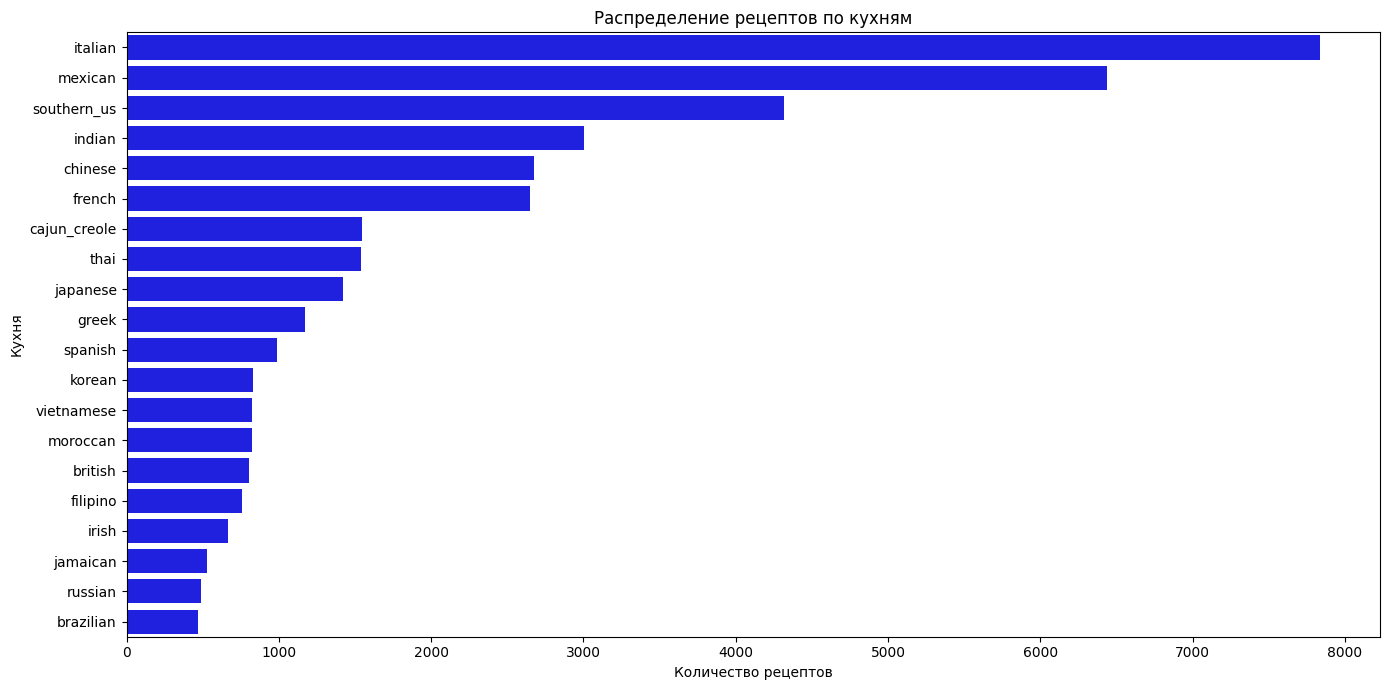

In [11]:
plt.figure(figsize=(14, 7))
sns.countplot(y='cuisine', data=df, order=df['cuisine'].value_counts().index, color="blue")
plt.title('Распределение рецептов по кухням')
plt.xlabel('Количество рецептов')
plt.ylabel('Кухня')
plt.tight_layout()
plt.show()


Наибольшее количество рецептов относится к итальянской и мексиканской кухням, значительно опережая остальные. Также заметно выделяются южноамериканская (southern_us), индийская, китайская и французская кухни.

## 2. Определение наиболее часто встречающихся ингредиентов  


In [12]:
ingredient_counter = Counter()
for ingr_list in df['ingredients']:
    ingredient_counter.update(ingr_list)

common_ingredients = ingredient_counter.most_common(25)

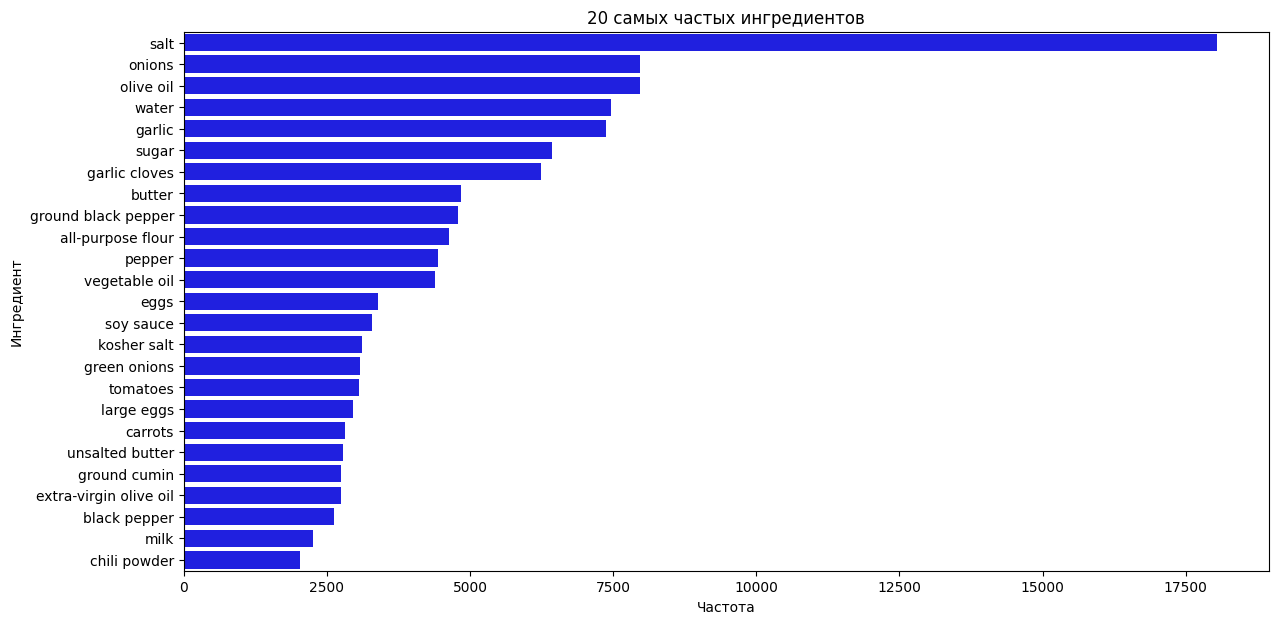

In [13]:
# Визуализация
ingredients, counts = zip(*common_ingredients)
plt.figure(figsize=(14, 7))
sns.barplot(x=list(counts), y=list(ingredients), color='blue')
plt.title('20 самых частых ингредиентов')
plt.xlabel('Частота')
plt.ylabel('Ингредиент')
plt.show()

Лидирующую позицию с большим отрывом занимает соль (salt), за ней следуют лук (onions) и оливковое масло (olive oil). Также часто используются такие базовые ингредиенты, как вода, чеснок, сахар и масло (butter). Это говорит о том, что большинство рецептов основано на универсальных компонентах, характерных для многих кухонь мира.

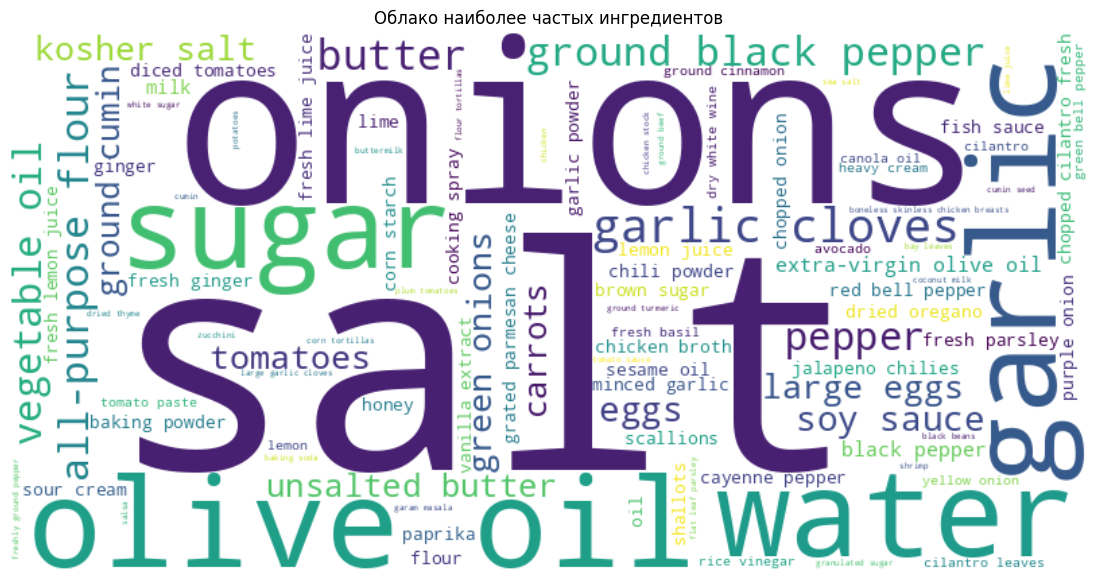

In [14]:
# Преобразуем счётчик в словарь
word_freq = dict(ingredient_counter.most_common(100))

# Создаём wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      random_state=42).generate_from_frequencies(word_freq)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако наиболее частых ингредиентов')
plt.show()

## 3. Подготовка данных для кластеризации (векторизация списков ингредиентов)  


### Преобразуем список ингредиентов в строку

In [15]:
df['ingredients']

0        [romaine lettuce, black olives, grape tomatoes...
1        [plain flour, ground pepper, salt, tomatoes, g...
2        [eggs, pepper, salt, mayonaise, cooking oil, g...
3                      [water, vegetable oil, wheat, salt]
4        [black pepper, shallots, cornflour, cayenne pe...
                               ...                        
39769    [light brown sugar, granulated sugar, butter, ...
39770    [KRAFT Zesty Italian Dressing, purple onion, b...
39771    [eggs, citrus fruit, raisins, sourdough starte...
39772    [boneless chicken skinless thigh, minced garli...
39773    [green chile, jalapeno chilies, onions, ground...
Name: ingredients, Length: 39774, dtype: object

In [16]:
df['ingredients_joined'] = df['ingredients'].apply(lambda x: ' '.join(x))
df.head()

cuisine                                        ingredients  \
0        greek  [romaine lettuce, black olives, grape tomatoes...   
1  southern_us  [plain flour, ground pepper, salt, tomatoes, g...   
2     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...   
3       indian                [water, vegetable oil, wheat, salt]   
4       indian  [black pepper, shallots, cornflour, cayenne pe...   

                                  ingredients_joined  
0  romaine lettuce black olives grape tomatoes ga...  
1  plain flour ground pepper salt tomatoes ground...  
2  eggs pepper salt mayonaise cooking oil green c...  
3                     water vegetable oil wheat salt  
4  black pepper shallots cornflour cayenne pepper...

### Векторизация ингредиентов

In [17]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['ingredients_joined'])

In [18]:
X.shape

(39774, 3010)

## 4. Кластеризация рецептов с помощью алгоритма KMeans (2 кластера)  


In [19]:
kmeans = KMeans(n_clusters=2, random_state=42)

In [20]:
# Применяем KMeans к данным
kmeans.fit(X)

KMeans(n_clusters=2, random_state=42)

In [21]:
df['cluster'] = kmeans.labels_

In [22]:
# Рецепты для каждого кластера
cluster_0 = df[df['cluster'] == 0]
cluster_1 = df[df['cluster'] == 1]

In [23]:
print("Рецепты для кластера 0:")
print(cluster_0[['cuisine', 'ingredients_joined']].head(7))

Рецепты для кластера 0:
        cuisine                                 ingredients_joined
1   southern_us  plain flour ground pepper salt tomatoes ground...
2      filipino  eggs pepper salt mayonaise cooking oil green c...
4        indian  black pepper shallots cornflour cayenne pepper...
6       spanish  olive oil salt medium shrimp pepper garlic cho...
8       mexican  olive oil purple onion fresh pineapple pork po...
9       italian  chopped tomatoes fresh basil garlic extra-virg...
10      italian  pimentos sweet pepper dried oregano olive oil ...


In [24]:
print("Рецепты для кластера 1:")
print(cluster_1[['cuisine', 'ingredients_joined']].head(7))

Рецепты для кластера 1:
     cuisine                                 ingredients_joined
0      greek  romaine lettuce black olives grape tomatoes ga...
3     indian                     water vegetable oil wheat salt
5   jamaican  plain flour sugar butter eggs fresh ginger roo...
7    italian  sugar pistachio nuts white almond bark flour v...
15    indian  tumeric vegetable stock tomatoes garam masala ...
16   british  greek yogurt lemon curd confectioners sugar ra...
17   italian  italian seasoning broiler-fryer chicken mayona...


## 5. Визуализация кластеров с помощью облаков слов  

### Функция для создания облака слов для каждого кластера


In [25]:
def plot_wordcloud(cluster_data, title):
    # Объединяем все ингредиенты в одну строку
    all_ingredients = ' '.join(cluster_data['ingredients_joined'])

    # Создаём облако слов
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_ingredients)

    # Визуализируем облако слов
    plt.figure(figsize=(14, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

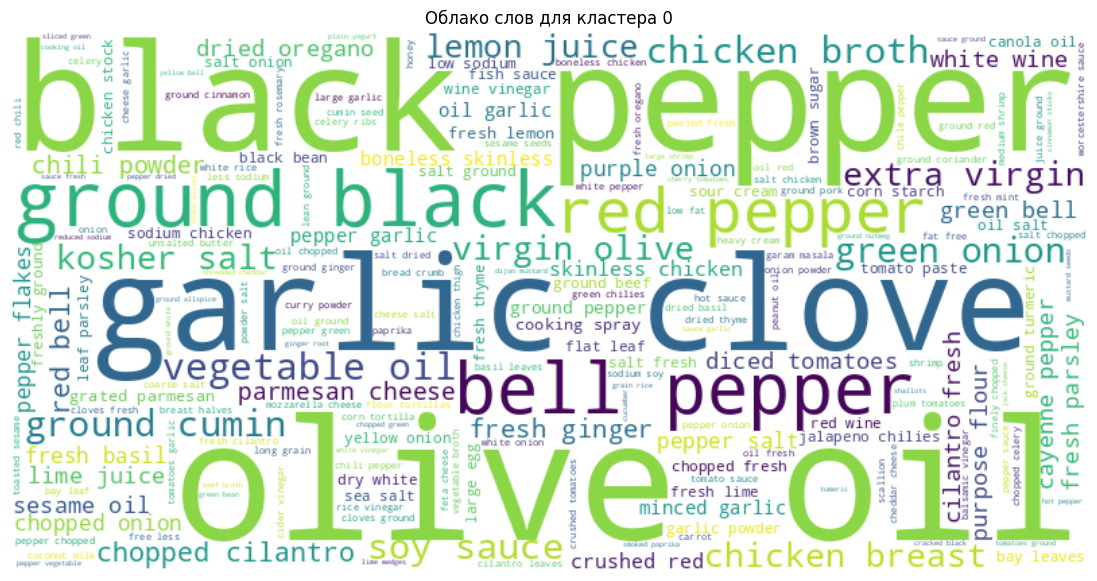

In [26]:
plot_wordcloud(cluster_0, 'Облако слов для кластера 0')

Облако слов для кластера 0 показывает, что наиболее часто встречающиеся ингредиенты - это черный перец и оливковое масло, что может указывать на преобладание рецептов средиземноморской кухни в этом кластере. Также часто встречаются чеснок, соль, растительное масло, куриный бульон и красный перец, что может говорить о наличии "общих" рецептов. В целом, кластер 0 характеризуется разнообразием рецептов, включающих широкий спектр ингредиентов.

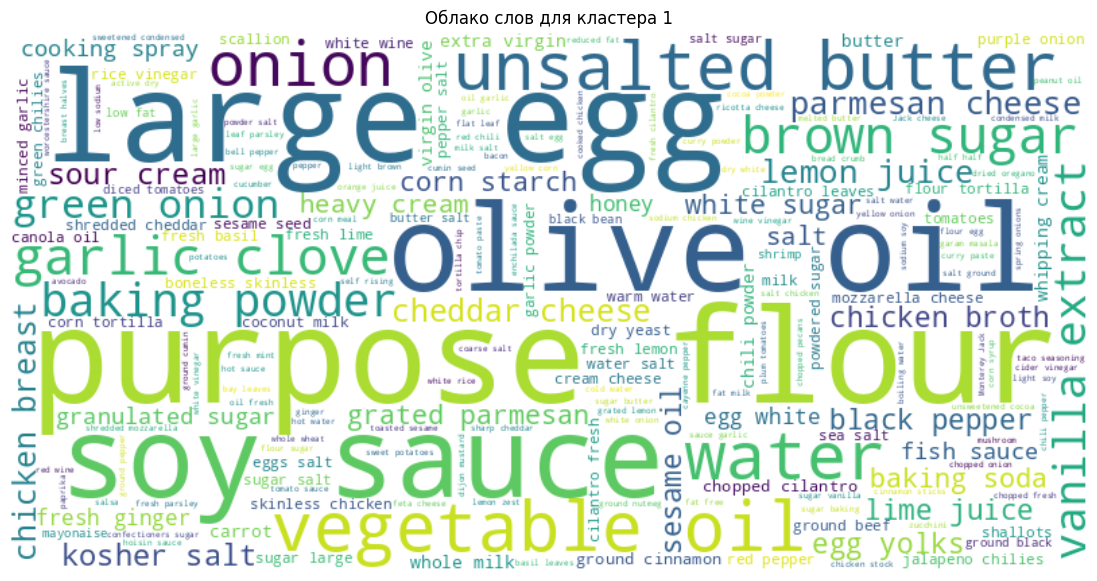

In [27]:
plot_wordcloud(cluster_1, 'Облако слов для кластера 1')

Облако слов для кластера 1 показывает, что в этом кластере часто встречаются оливковое и растительное масла, а также соевый соус, что указывает на возможное смешение рецептов из разных кухонь, включая азиатскую и средиземноморскую. Частое использование муки, сахара, яиц и воды говорит о наличии рецептов выпечки и соусов. В целом, кластер 1 характеризуется разнообразием рецептов из разных кухонь.

## 6. Кластеризация с другим количеством кластеров

In [28]:
silhouette_scores = []

# Диапазон для числа кластеров
range_of_k = range(2, 11)

for k in range_of_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)

    # Предсказания кластеров
    labels = kmeans.labels_

    # Вычисление силуэтного коэффициента
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Количество кластеров: {k}, силуэтный коэффициент: {silhouette_avg:.4f}")

Количество кластеров: 2, силуэтный коэффициент: 0.0627
Количество кластеров: 3, силуэтный коэффициент: 0.0512
Количество кластеров: 4, силуэтный коэффициент: 0.0176
Количество кластеров: 5, силуэтный коэффициент: 0.0179
Количество кластеров: 6, силуэтный коэффициент: 0.0118
Количество кластеров: 7, силуэтный коэффициент: 0.0145
Количество кластеров: 8, силуэтный коэффициент: 0.0100
Количество кластеров: 9, силуэтный коэффициент: 0.0094
Количество кластеров: 10, силуэтный коэффициент: 0.0056


Количество кластеров: 2, силуэтный коэффициент: 0.0627

Количество кластеров: 3, силуэтный коэффициент: 0.0512

Количество кластеров: 4, силуэтный коэффициент: 0.0176

Количество кластеров: 5, силуэтный коэффициент: 0.0179

Количество кластеров: 6, силуэтный коэффициент: 0.0118

Количество кластеров: 7, силуэтный коэффициент: 0.0145

Количество кластеров: 8, силуэтный коэффициент: 0.0100

Количество кластеров: 9, силуэтный коэффициент: 0.0094

Количество кластеров: 10, силуэтный коэффициент: 0.0056

In [29]:
silhouette_scores = [0.0627, 0.0512, 0.0176, 0.0179, 0.0118, 0.0145, 0.0100, 0.0094, 0.0056]

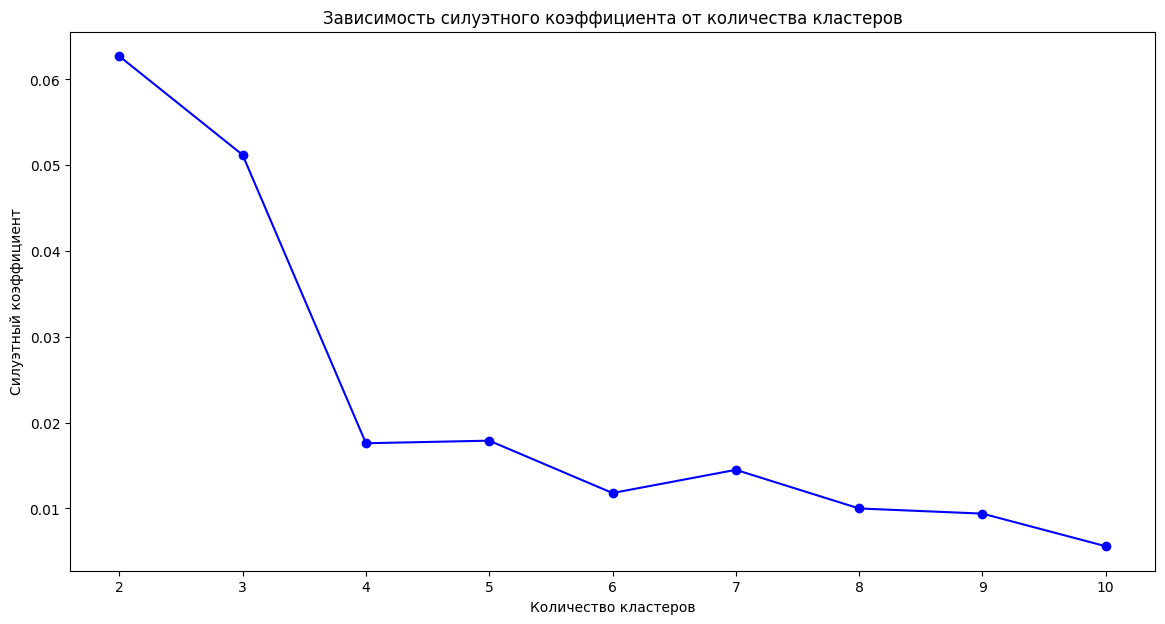

In [30]:
# Визуализация результатов
plt.figure(figsize=(14,7))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='blue')
plt.title("Зависимость силуэтного коэффициента от количества кластеров")
plt.xlabel("Количество кластеров")
plt.ylabel("Силуэтный коэффициент")
plt.show()

График показывает, что оптимальное количество кластеров для данного набора данных — 2, так как при этом значении силуэтный коэффициент достигает максимума. Увеличение числа кластеров приводит к снижению качества кластеризации, указывая на менее четкое разделение данных.

### Построение двуъ лучших моделей

In [31]:
# Обучим модель на 2 кластера
kmeans_2 = KMeans(n_clusters=2, random_state=42)
df['cluster_2'] = kmeans_2.fit_predict(X)

In [32]:
# Обучим модель на 3 кластера
kmeans_3 = KMeans(n_clusters=3, random_state=42)
df['cluster_3'] = kmeans_3.fit_predict(X)

Результаты кластеризации показали, что второй кластер содержит значительно больше рецептов, чем первый. Это может свидетельствовать о том, что в данных есть кухни, которые доминируют в общем числе рецептов, например, итальянская, индийская или китайская. Алгоритм KMeans, в отличие от методов, ориентированных на балансировку кластеров, стремится минимизировать внутрикластерные расстояния и может объединять рецепты с похожими ингредиентами в более крупные кластеры. Поэтому второй кластер оказался более многочисленным. Разбиение рецептов по кластерам отражает схожесть их ингредиентов, что подтверждается различиями в составе блюд.

In [33]:
print("Сравнение кластеров и кухни (K=3):")
print(pd.crosstab(df['cluster_3'], df['cuisine']))

Сравнение кластеров и кухни (K=3):
cuisine    brazilian  british  cajun_creole  chinese  filipino  french  greek  \
cluster_3                                                                       
0                170      116           964       86       129     838    721   
1                289      682           505      401       302    1797    449   
2                  8        6            77     2186       324      11      5   

cuisine    indian  irish  italian  jamaican  japanese  korean  mexican  \
cluster_3                                                                
0            1643    123     4137       271        87      31     2958   
1            1303    539     3668       195       691     188     3364   
2              57      5       33        60       645     611      116   

cuisine    moroccan  russian  southern_us  spanish  thai  vietnamese  
cluster_3                                                             
0               610      110         1031     

Первый кластер в основном включает такие кухни, как индийскую, итальянскую, мексиканскую

Второй кластер содержит более разнообразный состав с преобладанием японской, французской, североамериканской и мексиканской кухонь.

Третий кластер в основном включает такие кухни, как японская, китайская, тайская и вьетнамская, в то время как остальные кухни представлены в нём в значительно меньших количествах.

Это разделение может свидетельствовать о схожести ингредиентов и методов приготовления, характерных для этих восточноазиатских кухонь

## 7. Георграфическое разделение кухонь

**Европейские кухни:** греческая, британская, итальянская, французская, испанская, ирландская, русская, морокканская.

**Американские кухни:** южноамериканская (southern_us), креольская (cajun_creole), ямайская, мексиканская, бразильская.

**Азиатские кухни:** китайская, японская, тайская, вьетнамская, корейская, индийская, филиппинская.

In [34]:
# Географическое разделение кухонь
european = ['italian', 'french', 'spanish', 'greek', 'irish', 'british', 'russian', 'moroccan']
american = ['mexican', 'southern_us', 'cajun_creole', 'brazilian', 'jamaican']
asian = ['chinese', 'japanese', 'korean', 'thai', 'vietnamese', 'indian', 'filipino']

In [35]:
# Создадим столбец с географической категорией
def categorize_cuisine(cuisine):
    if cuisine in european:
        return 'European'
    elif cuisine in asian:
        return 'Asian'
    elif cuisine in american:
        return 'American'
    else:
        return 'Other'

df['region'] = df['cuisine'].apply(categorize_cuisine)

In [36]:
df.head()

cuisine                                        ingredients  \
0        greek  [romaine lettuce, black olives, grape tomatoes...   
1  southern_us  [plain flour, ground pepper, salt, tomatoes, g...   
2     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...   
3       indian                [water, vegetable oil, wheat, salt]   
4       indian  [black pepper, shallots, cornflour, cayenne pe...   

                                  ingredients_joined  cluster  cluster_2  \
0  romaine lettuce black olives grape tomatoes ga...        1          1   
1  plain flour ground pepper salt tomatoes ground...        0          0   
2  eggs pepper salt mayonaise cooking oil green c...        0          0   
3                     water vegetable oil wheat salt        1          1   
4  black pepper shallots cornflour cayenne pepper...        0          0   

   cluster_3    region  
0          1  European  
1          0  American  
2          2     Asian  
3          1     Asian  
4          0     Asian

### Для двух кластеров (k=2)

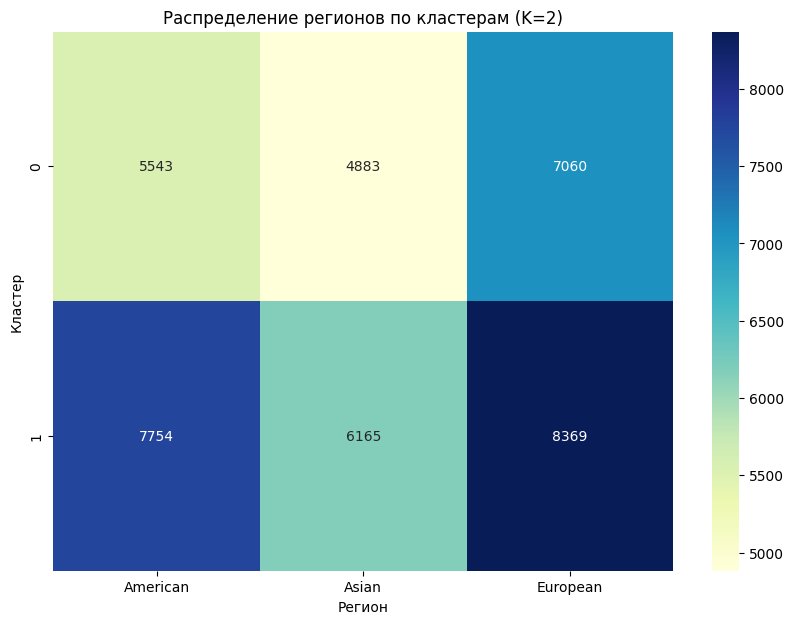

In [37]:
# Подсчёт количества блюд в каждом регионе по кластерам (K=2)
region_cluster_counts = pd.crosstab(df['cluster_2'], df['region'])

# Построение тепловой карты
plt.figure(figsize=(10, 7))
sns.heatmap(region_cluster_counts, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Распределение регионов по кластерам (K=2)')
plt.xlabel('Регион')
plt.ylabel('Кластер')
plt.show()

На тепловой карте видно, что второй кластер значительно преобладает над первым по количеству рецептов в каждом регионе, что указывает на неравномерное распределение рецептов между кластерами и возможное преобладание "общих" рецептов в кластере 1.

### Для трёх кластеров (k=3)

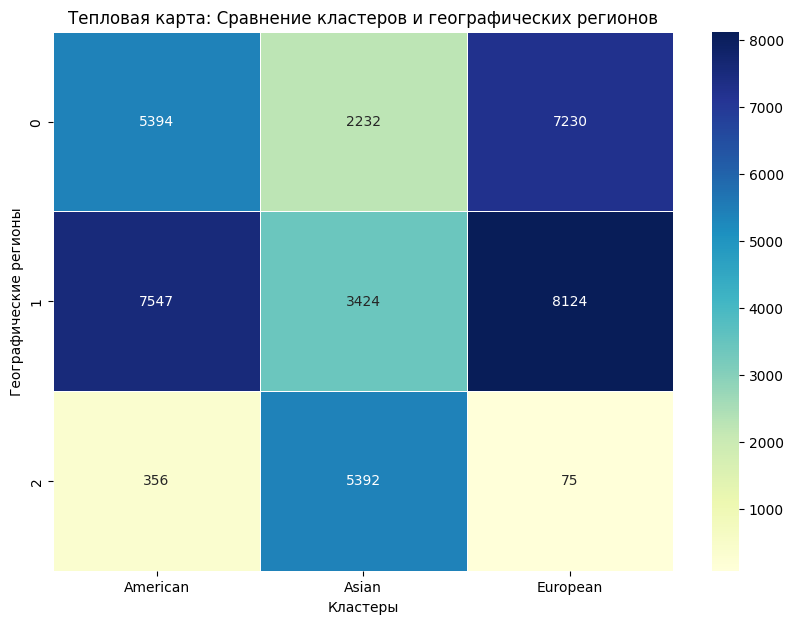

In [38]:
region_cluster_table = pd.crosstab(df['cluster_3'], df['region'])

# Построим тепловую карту
plt.figure(figsize=(10, 7))
sns.heatmap(region_cluster_table, annot=True, cmap="YlGnBu", fmt="d", linewidths=0.5)
plt.title("Тепловая карта: Сравнение кластеров и географических регионов")
plt.xlabel("Кластеры")
plt.ylabel("Географические регионы")
plt.show()

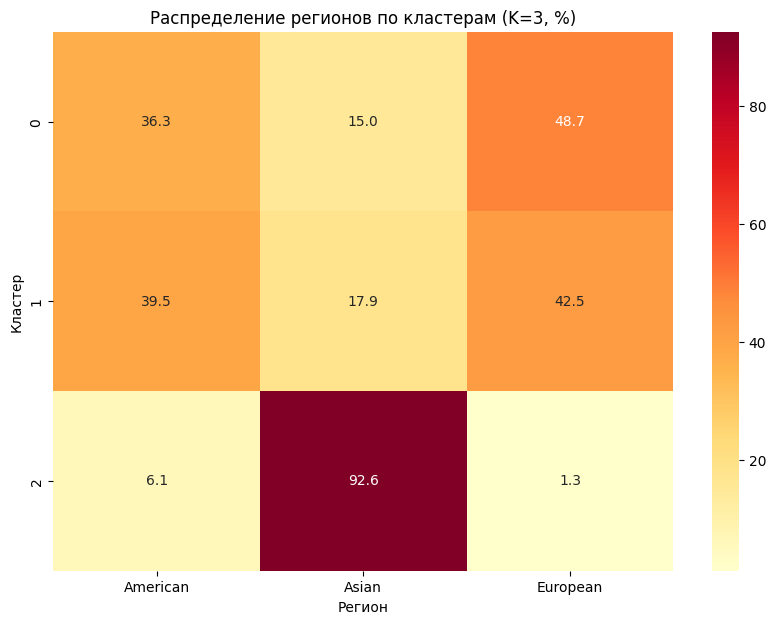

In [39]:
region_cluster_counts = pd.crosstab(df['cluster_3'], df['region'])

# Преобразуем в проценты: делим каждую строку на сумму по строке
region_cluster_percent = region_cluster_counts.div(region_cluster_counts.sum(axis=1), axis=0) * 100

# Построение тепловой карты
plt.figure(figsize=(10, 7))
sns.heatmap(region_cluster_percent, annot=True, fmt=".1f", cmap='YlOrRd')
plt.title('Распределение регионов по кластерам (K=3, %)')
plt.xlabel('Регион')
plt.ylabel('Кластер')
plt.show()

Тепловая карта показывает распределение рецептов по трём кластерам и географическим регионам. Кластер 2 явно соответствует азиатской кухне, кластер 1 содержит много "общих" рецептов из разных регионов, а кластер 0 - в основном европейские и американские рецепты. Это указывает на то, что кластеризация выявила различия между кухнями, но также показала наличие "общих" рецептов, встречающихся в разных регионах.

## 8. Применение альтернативных алгоритмов кластеризации

### 1. Agglomerative Clustering (иерархическая кластеризация)


In [40]:
df_sample = resample(df, n_samples=15000, random_state=42)
X_sample = vectorizer.transform(df_sample['ingredients_joined'])

На всём мномжестве не хватает ОЗУ

In [41]:
# Вычисляем косинусное расстояние
cosine_dist = cosine_distances(X_sample)

In [42]:
# Агломеративная кластеризация
agglo = AgglomerativeClustering(n_clusters=3, metric='precomputed', linkage='average')
labels_agglo = agglo.fit_predict(cosine_dist)

In [43]:
# Silhouette
silhouette_agglo = silhouette_score(cosine_dist, labels_agglo, metric='precomputed')
print(f"Silhouette Score (sampled): {silhouette_agglo:.4f}")

# Сохраняем в sample DataFrame
df_sample['agglo_cluster'] = labels_agglo

Silhouette Score (sampled): 0.1478


Silhouette Score (sampled): 0.1478

### 2. Spectral Clustering

In [44]:
# Вычисляем косинусное сходство
cosine_sim = cosine_similarity(X_sample)

In [45]:
# Spectral Clustering на основе сходства
spectral = SpectralClustering(
    n_clusters=3,
    affinity='precomputed',
    assign_labels="kmeans",
    random_state=42
)

labels_spectral = spectral.fit_predict(cosine_sim)

In [46]:
# Silhouette
silhouette_avg = silhouette_score(X_sample, labels_spectral, metric='cosine')
print(f"Silhouette Score (Spectral, cosine): {silhouette_avg:.4f}")

df_sample['spectral_cluster'] = labels_spectral

Silhouette Score (Spectral, cosine): 0.0691


Silhouette Score (Spectral, cosine): 0.0691

Результаты кластеризации показывают, что все использованные методы имеют низкие значения Silhouette Score. Однако среди них Agglomerative Clustering демонстрирует лучший результат с показателем 0.1478, что представляет собой небольшой прирост по сравнению с другими методами.

Для Spectral Clustering с косинусным расстоянием результат оказался еще хуже, с Silhouette Score в 0.0666

KMeans с 2 и 3 кластерами также показал низкие значения Silhouette Score (0.0627 и 0.0512 соответственно)

Таким образом, Agglomerative Clustering показал лучший результат среди всех рассмотренных методов, но в целом все методы указывают на отсутствие четкой кластерной структуры в данных.

## 9. Оценка качества кластеризации исходя из предположения, что "кухня"(cuisine) — истинная метка принадлежности кластеру

In [47]:
df_sample.head()

cuisine                                        ingredients  \
15795       french  [olive oil, thyme leaves, dried lavender, lemo...   
860    southern_us  [pepper, spicy brown mustard, boneless chicken...   
38158      chinese  [blue crabs, peeled fresh ginger, soy sauce, s...   
11284      italian  [marsala wine, butter, olive oil, fresh mushro...   
6265       mexican  [tomato purée, butter, salt, taco seasoning, p...   

                                      ingredients_joined  cluster  cluster_2  \
15795  olive oil thyme leaves dried lavender lemon ze...        1          1   
860    pepper spicy brown mustard boneless chicken br...        1          1   
38158  blue crabs peeled fresh ginger soy sauce salt ...        1          1   
11284  marsala wine butter olive oil fresh mushrooms ...        1          1   
6265   tomato purée butter salt taco seasoning panko ...        0          0   

       cluster_3    region  agglo_cluster  spectral_cluster  
15795          1  European              0                 2  
860            1  American              0                 2  
38158          2     Asian              0                 0  
11284          1  European              0                 2  
6265           0  American              0                 2

### Оценка Agglomerative Clustering

In [48]:
true_labels = df_sample['cuisine']
predicted_labels = df_sample['agglo_cluster']

ami = adjusted_mutual_info_score(true_labels, predicted_labels)
v_measure = v_measure_score(true_labels, predicted_labels)

print(f"Adjusted Mutual Information (AMI): {ami:.4f}")
print(f"V-Measure: {v_measure:.4f}")

Adjusted Mutual Information (AMI): 0.0001
V-Measure: 0.0003


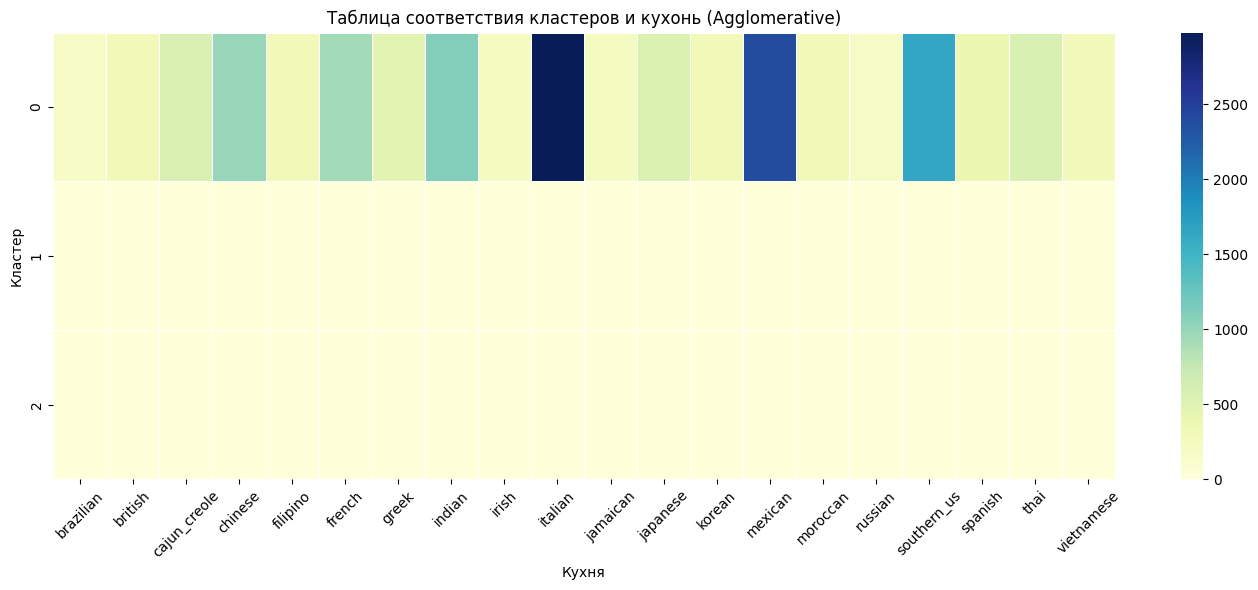

In [49]:
contingency_table = pd.crosstab(df_sample['agglo_cluster'], df_sample['cuisine'])

plt.figure(figsize=(14, 6))
sns.heatmap(contingency_table, cmap="YlGnBu", linewidths=0.5)
plt.title("Таблица соответствия кластеров и кухонь (Agglomerative)")
plt.ylabel("Кластер")
plt.xlabel("Кухня")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

На тепловой карте видно, что агломеративная кластеризация не справилась с задачей кластеризации кухонь: почти все кухни отнесены к одному кластеру (кластер 0), а кластеры 1 и 2 остались практически пустыми. Это говорит о слабой способности модели выявлять различия между группами кухонь или о том, что входные признаки не дали алгоритму достаточной информации для разделения.

### Оценка Spectral Clustering

In [50]:
true_labels = df_sample['cuisine']
predicted_labels = df_sample['spectral_cluster']

ami = adjusted_mutual_info_score(true_labels, predicted_labels)
v_measure = v_measure_score(true_labels, predicted_labels)

print(f"Adjusted Mutual Information (AMI): {ami:.4f}")
print(f"V-Measure: {v_measure:.4f}")

Adjusted Mutual Information (AMI): 0.1530
V-Measure: 0.1536


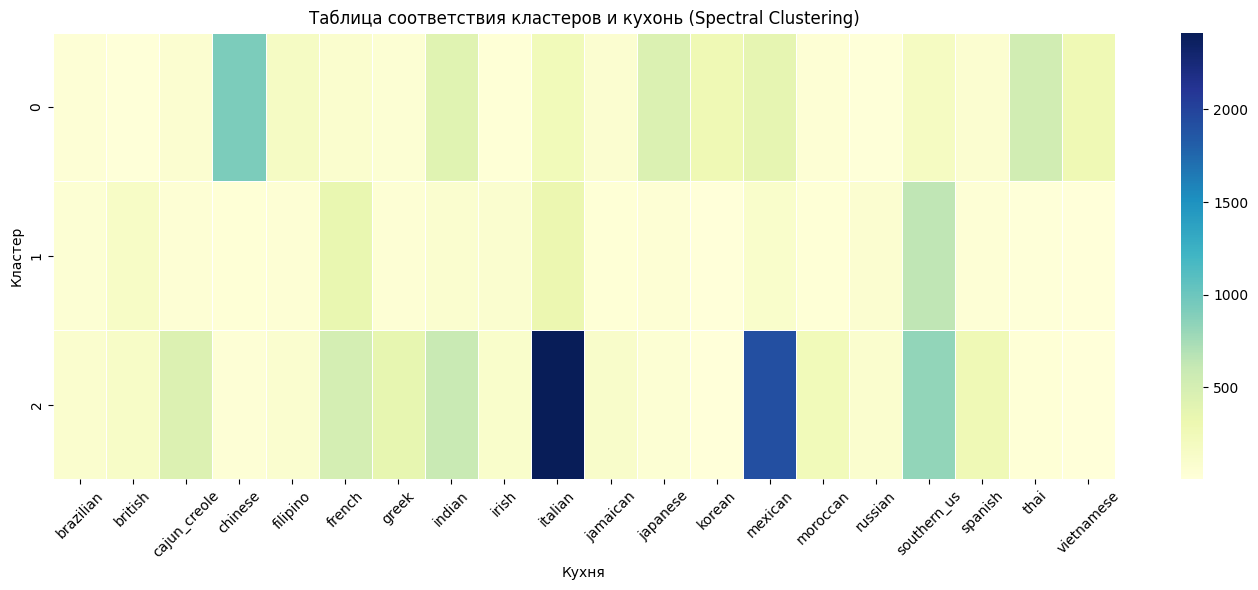

In [51]:
contingency_table = pd.crosstab(df_sample['spectral_cluster'], df_sample['cuisine'])

plt.figure(figsize=(14, 6))
sns.heatmap(contingency_table, cmap="YlGnBu", linewidths=0.5)
plt.title("Таблица соответствия кластеров и кухонь (Spectral Clustering)")
plt.ylabel("Кластер")
plt.xlabel("Кухня")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Spectral Clustering показал более равномерное распределение кухонь по кластерам по сравнению с Agglomerative: все три кластера содержат данные, и видно, что кухни частично разделены по кулинарным особенностям. Например, итальянская и мексиканская кухни ярко выражены в кластере 2, тогда как southern US и french попали в разные группы, что может отражать различия в стилях. Однако остаётся некоторое смешение — например, китайская кухня оказалась в кластере 0, где также много разных кухонь. В целом, результат лучше

Несмотря на то, что Agglomerative Clustering показал более высокий силуэтный коэффициент (0.1478), его кластеры практически не совпадают с реальными метками кухни (AMI = 0.0001, V-Measure = 0.0003). В то же время, Spectral Clustering формирует менее плотные, но более осмысленные с точки зрения реального распределения кухни кластеры (AMI = 0.1450, V-Measure = 0.1456). Это говорит о том, что Spectral Clustering лучше отражает структуру данных, соответствующую реальным категориям.

## 10. Визуализация результатов и выводы

### TSNE

In [52]:
# Уменьшаем размерность до 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_sample.toarray())

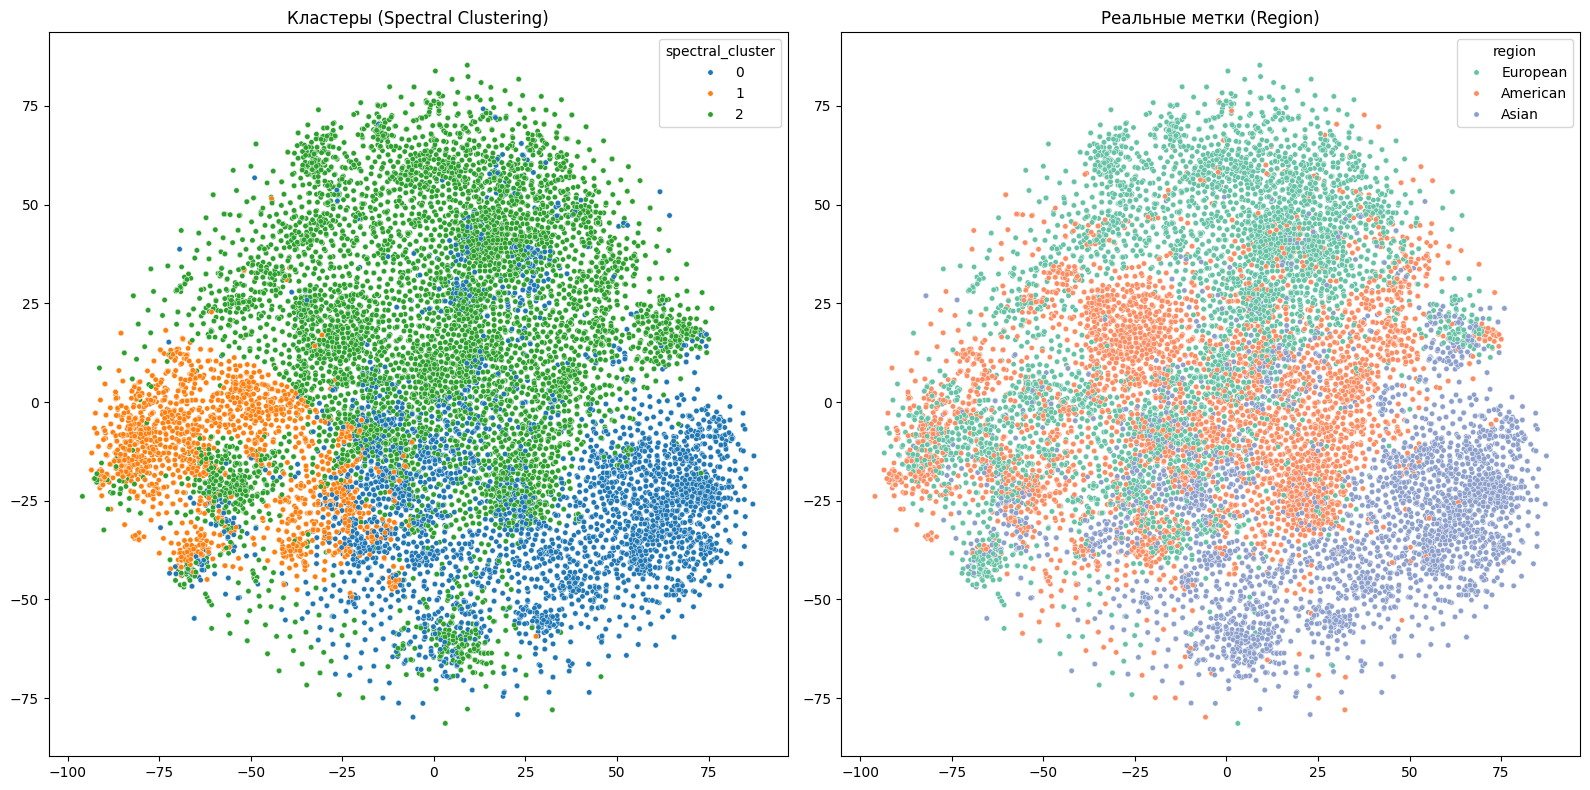

In [53]:
df_sample['region'] = df_sample['cuisine'].apply(categorize_cuisine)


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=X_tsne[:, 0], y=X_tsne[:, 1],
    hue=df_sample['spectral_cluster'],
    palette='tab10', legend='full', s=15
)
plt.title("Кластеры (Spectral Clustering)")

# Визуализация по регионам (географическим категориям)
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=X_tsne[:, 0], y=X_tsne[:, 1],
    hue=df_sample['region'],
    palette='Set2', legend='full', s=15
)
plt.title("Реальные метки (Region)")

plt.tight_layout()
plt.show()

На визуализации хорошо видно, как работают результаты кластеризации методом Spectral Clustering по сравнению с реальными метками кухонь. Слева три чётко различимых кластера, каждый из которых занимает свою плотную область на плоскости после понижения размерности с помощью t-SNE. Это говорит о том, что алгоритм смог выявить некоторые общие структуры в данных, особенно выделяется контраст между кластерами 0 и 1, в то время как кластер 2 частично пересекается с обоими, что может указывать на наличие смешанных признаков между категориями. Правая часть, где показаны реальные метки кухонь, выглядит гораздо менее структурированной — классы сильно пересекаются, границы между ними размыты, и цветов заметно больше, что указывает на большее количество категорий. Это логично, так как кухни могут делиться схожими ингредиентами и рецептурными особенностями, что усложняет задачу кластеризации.

### PCA

In [54]:
# Уменьшаем размерность до 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample.toarray())

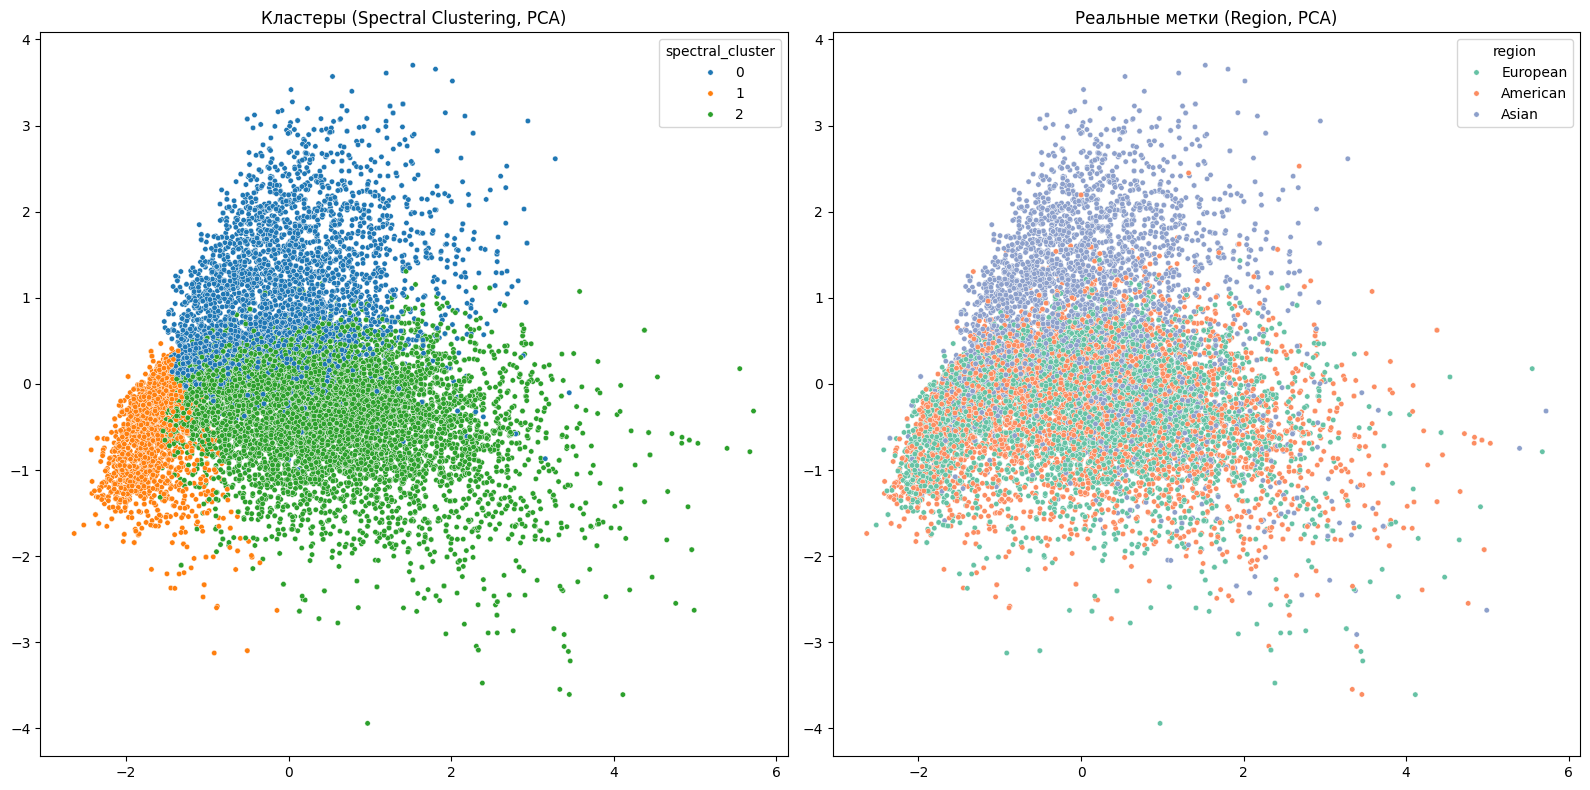

In [55]:
# Визуализация по предсказанным кластерам (Spectral Clustering)
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=df_sample['spectral_cluster'],
    palette='tab10', legend='full', s=15
)
plt.title("Кластеры (Spectral Clustering, PCA)")

# Визуализация по географическим регионам
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=df_sample['region'],
    palette='Set2', legend='full', s=15
)
plt.title("Реальные метки (Region, PCA)")

plt.tight_layout()
plt.show()

In [56]:
true_labels = df_sample['cuisine']  # или df_sample['region']

# Предсказанные кластеры
predicted_clusters = df_sample['spectral_cluster']

# Вычисляем ARI
ari_score = adjusted_rand_score(true_labels, predicted_clusters)

print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

Adjusted Rand Index (ARI): 0.0933


На этой визуализации представлено сравнение кластеризации Spectral Clustering и реальных меток кухонь после понижения размерности с помощью PCA. В отличие от предыдущего примера с t-SNE, где структура кластеров выглядела более разделённой, здесь проекция на плоскость получилась более сглаженной, и кластеры выглядят менее чётко очерченными, особенно кластер 2, который растекается вширь и пересекается с другими. Тем не менее, различие между кластерами 0 и 1 по-прежнему хорошо заметно. Это говорит о том, что PCA сохраняет глобальные направления дисперсии, но теряет часть локальной структуры, которую t-SNE умеет подчёркивать.